In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
sql_base = automap_base()
# reflect the tables
sql_base.prepare(autoload_with=engine)

In [18]:
# View all of the classes that automap found
sql_base.classes.keys()

['station', 'measurement']

In [19]:
# Save references to each table
Station = sql_base.classes.station
Measurement = sql_base.classes.measurement

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_str = most_recent_date_row.date
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

print(most_recent_date)
print(one_year_ago)

2017-08-23 00:00:00
2016-08-23 00:00:00


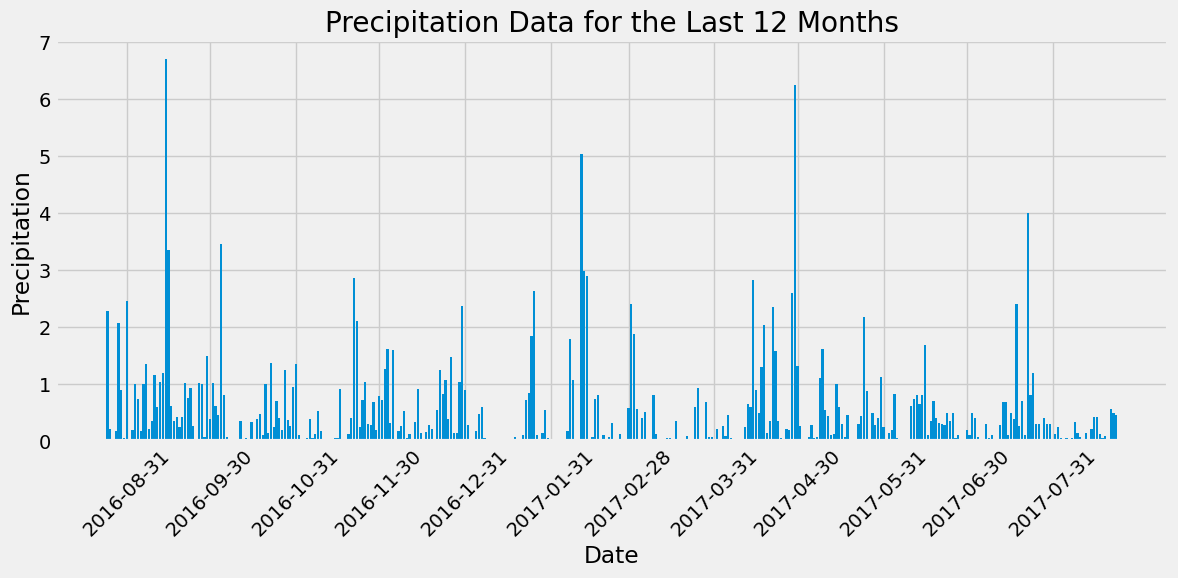

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Perform a query to retrieve the data and precipitation scores
query = sqlalchemy.text(f"SELECT date, prcp FROM Measurement WHERE date >= :one_year_ago")
results = session.execute(query, {'one_year_ago': one_year_ago})

#dictionary to store data
data = {'date': [], 'precipitation': []}

#get data from query results
for row in results:
    data['date'].append(row[0])
    data['precipitation'].append(row[1])

#create dataframe
df = pd.DataFrame(data)

#sort by date
df = df.sort_values(by='date')

#convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

#filter df
df_filtered = df[(df['date'] >= one_year_ago) & (df['date'] <= most_recent_date)]

#plot data
plt.figure(figsize=(12, 6))
plt.bar(df_filtered['date'], df_filtered['precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)

date_range = pd.date_range(start=one_year_ago, end=most_recent_date, freq='M')
plt.xticks(date_range, [date.strftime('%Y-%m-%d') for date in date_range])

plt.tight_layout()
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df_filtered['precipitation'].describe()

# Print the summary statistics
print(summary_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

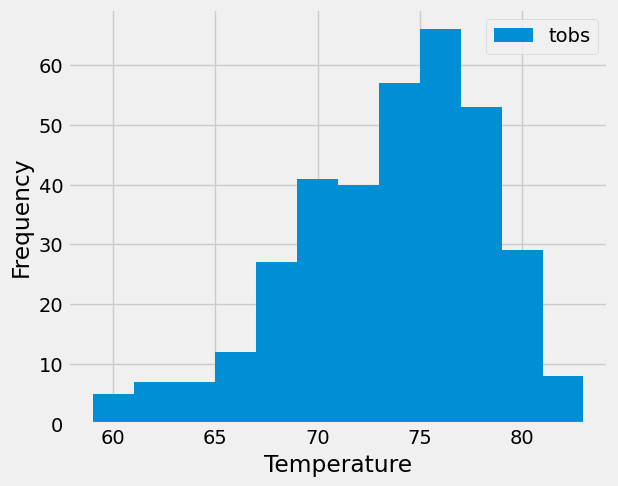

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()